---
title: "Chapter 3, Part 2: Feature Selection and Regularization"
subtitle: "Machine Learning"
date: "February 2026"
date-format: "MMMM YYYY"
author: 
  - F.San Segundo & N.Rodríguez
bibliography: ../exclude/mlmiin.bib
execute:
  echo: true
code-overflow: wrap
format: 
  html: 
    toc: true
    code-tools: true
    code-fold: show
    code-summary: "Hide the code"
    embed-resources: true
---

---

::: {.callout-warning icon=false}

##### Setting the working directory

We begin by using cd to make sure we are in the right folder.

:::

In [1]:
%cd 3_2_FeatureSelection_Regularization

/wd/3_2_FeatureSelection_Regularization


# Session Setup

::: {.callout-note  icon=false}

### Libraries

Let us begin by loading the libraries we will use.

:::



In [2]:
### Load necessary modules -------------------------------
# interactive plotting
# %matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set()
import statsmodels.api as sm


# Data management libraries
import numpy as np 
import pandas as pd
import scipy.stats as stats

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Feature selection libraries
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.feature_selection import RFECV

# Machine learning libraries
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Connecting statsmodels with sklearn via sklearn2pmml and patsy 
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor 

from sklearn2pmml.statsmodels import StatsModelsRegressor

# Others
import warnings

# patsy for lineal model formula language
import patsy as ps
from patsy_utils.patsy_formulaic_transformer import FormulaTransformer

---

#  Variable Selection Methods

::: {.callout-note icon=false}

## The Parsimony Principle

This principle states that we should prefer simpler models over more complex ones. That is, we always prefer a model which is as simple as possible, while keeping a good predictive performance (meaning high performance and generalization). In Linear Regression Models we can try to achieve that goal by removing variables from the model or by shrinking their coefficients to reduce their influence on the model's predictions. We do that while watching the impact of their removal on the model's performance. 

A brute force approach to this problem consists in trying all possible subsets of the input variables. If there are p of them that means that we need to train
$$1 + p + \binom{p}{2} + \cdots + + \binom{p}{p} = 2^p$$
different models in order to select the best one. For a moderate size example dataset, like the $p=10$ that we will see below, that means training $2^{10} = 1024$ models. And if you need to use cross validation to get robust results then we end up training quite a lot of models. For large size datasets this method will be too costly in terms of computation. 

:::

::: {.callout-note icon=false}

## Heuristic methods: strategies for variable selection

Instead of doing that we can choose to explore only a part of the whole collection of possible models, each one with a different choice of variables. How do we select that **partial collection of models to explore?** There are two natural strategies that you can easily come up with:

+ **Forward selection:** Start with a model without input variables (only the intercept, equal to $\bar Y$). Then for each value $k$ from 1 to $p$ (the number of inputs) take your current model and **add one variable** that the model does not use. Do that for every possible such variable (there are $p - k$ of them), fit the corresponding model (now with $k$ inputs) and select the *best model* among those.  
</br>  

+ **Backward selection:** Start with a model that uses all the $p$ input variables. Then for each value $k$ from 1 to $p$ take your current model and **remove one variable** that the model uses. Do that for every possible such variable (there are $p - k + 1$ of them), fit the corresponding model (now with $p - k$ inputs) and select the *best model* among those .  

Any of those two methods results in a collection of $p$ models, using from 1 to $p$ inputs. Our final model is the best one of them, unless their performance is very similar. More among choosing the best model in a moment. In that case we may consider a simpler, more interpretable model at the expense of a little predictive performance. 



Both forward and backward strategies use two types of model comparisons. 

+ In **horizontal comparisons** we need to compare models with the same number of inputs. This is a simpler problem and any performance measure such as $R^2_{adj}$ or $SS_{residual}$ can be used here to select the best one.  
</br>   

+ But in **vertical comparisons** we need to compare models with a different number of predictors, and that is a harder problem. For example, using variable selection in a model with say $p = 100$ predictors means that we need to compare a model with 2 predictors against a model with 95 predictors. And this is a problem because adding more variables always increases the value of $R^2$. IN particular the model with all the inputs is bound to have the largest value of $R^2$. So we need a different strategy to compare these different-size models. 

:::

---

::: {.callout-note icon=false}

## Vertical comparison: models with different number of input variables

There are two frequently used approaches for this task:

+ You can use a performance measure that takes the number of inputs into account. A traditional choice is the **adjusted R^2**. But its theoretical foundation is not as solid as in the case of more modern alternatives, such as the **Mallows $C_p$**
  $$C_p = \dfrac{1}{n}(SS_{residual} + 2\,p\,\hat\sigma^2)\quad\text{ where }\hat\sigma^2\text{ is an estimate of the variance of the error}$$
  or the **Akaike Information Criterion (AIC)**
  $$AIC = \dfrac{1}{n\hat\sigma^2}(SS_{residual} + 2\,p\,\hat\sigma^2) + \text{constant}$$
  or the **Bayesian Information Criterion (BIC)**
  $$AIC = \dfrac{1}{n\hat\sigma^2}(SS_{residual} + \log(n)\,p\,\hat\sigma^2)$$
  These measures are similar, as you can see. and they all include the number of inputs $p$ of the model. In all three cases the formulas shown above correspond to linear models fitted using least squares. And in all of them a model with a lower value of this measures is considered a better model. 

+ A second approach is to **use cross validation to compare the models**. We use one of the folds to train models of all sizes, getting a validation score for each size and each fold. Then we compute the average of these scores *across folds* and use it to select the best size. Call it $p_0$. The problem here is that the set of $p_0$ variables for each fold may be different. So our final step is to select the best model of size using the full training set.

:::

---

# Variable Selection in Python

::: {.callout-note icon=false}

## A Synthetic Example Dataset

We will use a datset with 10 numeric input variables to practice these variable selection methods in Python. We begin by loading the data and taking a look at the first few rows of the table. The output variable `Y` is in the last column of the table.

:::

In [3]:
df = pd.read_csv("./3_2_data01.csv")
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Y
0,0.375265,1.584437,-2.601827,0.022447,-1.742627,-0.687230,-2.332911,-0.522880,-0.470547,0.169020,1.378568,3.401781
1,-2.628640,-6.398784,1.584658,-0.046849,0.202249,1.630798,3.696776,0.383786,0.137692,0.422389,0.797784,4.195411
2,0.968450,3.151469,3.797902,-0.615858,-0.992719,0.032080,2.594655,0.416864,0.698120,0.177978,0.846438,2.289632
3,1.451148,1.620372,-0.555819,0.005467,0.445291,1.496196,0.673055,0.779617,0.010274,-0.876502,-1.149223,6.289907
4,-0.207422,1.286931,-1.179233,1.834709,1.260945,0.036981,-1.982970,1.794626,-0.431231,0.659964,0.130603,-0.784177


::: {.callout-note icon=false}

## Standard Names and Train/Test Split 

We proceed as usual to benefit from the already available code. 

:::

In [4]:
output = "Y"
num_inputs = ["X" + str(i) for i  in range(1, df.shape[1])]
cat_inputs = []
inputs = num_inputs + cat_inputs
X = df[inputs]
Y = df[output]

Next we create the train/test split.

In [5]:
XTR, XTS, YTR, YTS = train_test_split(
    X, Y,
    test_size = 0.2,  
    random_state = 1) 

dfTR = pd.DataFrame(XTR, columns=inputs)
dfTR[output] = YTR
dfTS = pd.DataFrame(XTS, columns=inputs)
dfTS[output] = YTS

::: {.callout-note icon=false}

## EDA: pairplot

This synthetic dataset contains no missing data and requires next to no processing. We will just make a pairplot to get a picture of some relations between variables.

:::

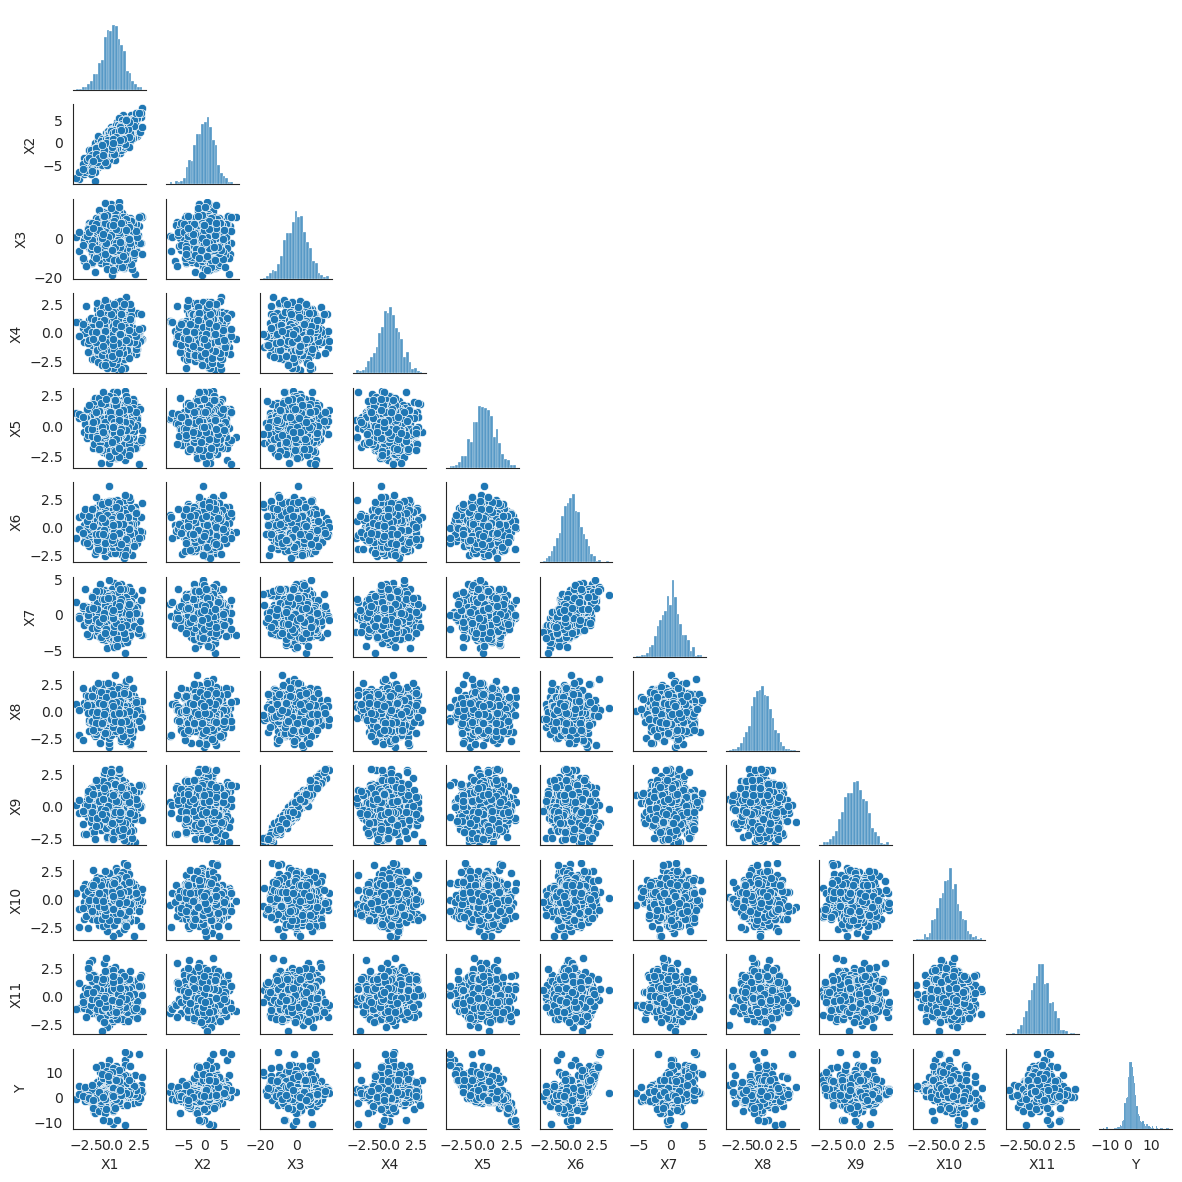

In [6]:
sns.set_style("white")
sns.pairplot(dfTR, corner=True, height=1, aspect=1);

In [7]:
XTR.corr()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
X1,1.000000,0.800172,-0.017546,-0.003350,-0.032179,-0.010736,-0.036970,-0.029899,-0.020021,-0.011684,-0.056911
X2,0.800172,1.000000,-0.002804,-0.004936,-0.024655,-0.001665,-0.052179,0.008793,-0.007839,-0.053868,-0.057638
X3,-0.017546,-0.002804,1.000000,-0.052395,-0.028096,-0.066732,-0.022051,-0.013028,0.968926,-0.018638,-0.006310
X4,-0.003350,-0.004936,-0.052395,1.000000,-0.016979,0.028705,0.052662,-0.041596,-0.058323,0.004816,-0.001033
X5,-0.032179,-0.024655,-0.028096,-0.016979,1.000000,-0.040766,-0.050736,-0.014336,-0.020022,-0.027139,-0.046829
X6,-0.010736,-0.001665,-0.066732,0.028705,-0.040766,1.000000,0.596393,0.005231,-0.065437,0.065676,-0.034175
X7,-0.036970,-0.052179,-0.022051,0.052662,-0.050736,0.596393,1.000000,-0.004117,-0.025989,0.045109,-0.069177
X8,-0.029899,0.008793,-0.013028,-0.041596,-0.014336,0.005231,-0.004117,1.000000,-0.026976,0.001250,-0.002293
X9,-0.020021,-0.007839,0.968926,-0.058323,-0.020022,-0.065437,-0.025989,-0.026976,1.000000,-0.021060,0.000606
X10,-0.011684,-0.053868,-0.018638,0.004816,-0.027139,0.065676,0.045109,0.001250,-0.021060,1.000000,-0.007986


There are some obvious high correlations in the plot. The correlation matrix can be used to confirm them. We can also use a heatmap to help visualize the matrix. This is specially useful when the number of variables is large.

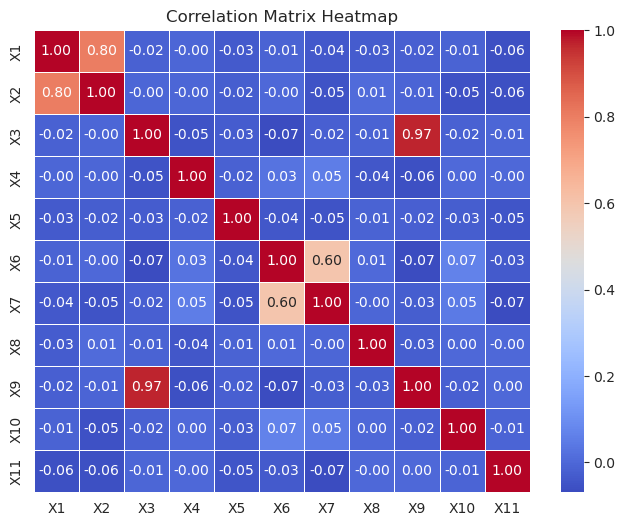

In [8]:
plt.figure(figsize=(8, 6))
sns.heatmap(XTR.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Looking at the pair plot or the heatmap it is clear that we can probably drop one of `X1` and `X2` and also one of `X3` and `X9`. But what about e.g. `X6` and `X11`? Are these variables part of the best model? And of course: how can we apply these ideas to models with hundreds of input variables, where manual inspection of plots and matrices is not feasible?

---

::: {.callout-note icon=false}

### Sequential Feature Selection in Python

The forward and backward selection strategies described above are implemented (in basic form) in the [`SequentialFeatureSelector` class of scikit](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html). Let us see how to apply the backward selection strategy to our dataset. We will do this inside the framework that we have met in the previous session, using a pipeline that includes the formula for the model that uses the whole set of input variables. 

:::

In this dataset there are no categorical inputs amd so we use `passthrough` in the preprocessing step of the pipeline. Uncomment the last line from this cell if you want to see the effect of preprocessing on the training dataset.

In [9]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler().set_output(transform="pandas"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_inputs),
        ('cat', 'passthrough', cat_inputs)
        ])

preprocessor.set_output(transform='pandas')
# preprocessor.fit_transform(XTR)


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


Next we define the model formula. Note that we have added `num__` to the names so that the formula fits nicely inside the naming conventions used by the pipeline. Note also that the formula uses `-1` to remove theintercept from the design matrix. This is because the `sfs` step in the pipeline below has `fit_intercept = True` to simplify the processing of the selected inputs in the code below (otherwise the intercept coming from the formula gets mixed in with the inputs and things get complicated). 

In [10]:
model_Formula = " + ".join(["num__"+ item for item in inputs])
model_Formula = model_Formula + " - 1"
model_Formula

'num__X1 + num__X2 + num__X3 + num__X4 + num__X5 + num__X6 + num__X7 + num__X8 + num__X9 + num__X10 + num__X11 - 1'

Now we are ready to create the pipeline for `SequentialFeatureSelector`. This function requires us to select a number of features (and the backward or forward direction) in advance. Let us use it to select a model with 6 features. 

In [11]:
num_features = 6

num_folds = 10

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    SFS_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ("formula", FormulaTransformer(model_Formula)),
        ('sfs', SequentialFeatureSelector(StatsModelsRegressor(OLS, fit_intercept = True,
                                                                scoring='neg_mean_squared_error'), 
                                                                n_features_to_select= num_features,
                                                                direction='forward',
                                                                cv=num_folds))])    


Now we fit the pipeline.

In [12]:
SFS_pipe.fit(XTR, YTR)

,steps,"[('preprocessor', ...), ('formula', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


To see the selected features run the code cell below. The first line makes sure that the names of the input variables are kept through the pipeline. Then we look at the `support` of the selected model, which is a boolean vector that indicates which variables were used in the model. And finally we show these variables in `varSelection`.

In [13]:
SFS_pipe.named_steps["sfs"].feature_names_in_ = np.array(inputs)
isVarSelected = SFS_pipe.named_steps["sfs"].support_.tolist()
varSelection = SFS_pipe.named_steps["sfs"].feature_names_in_[isVarSelected].tolist()
varSelection

['X1', 'X3', 'X4', 'X5', 'X6', 'X10']

---

::: {.callout-note icon=false}

### Examining the Selected Model

The model itself can be accessed with:

:::

In [14]:
SFS_pipe_model = SFS_pipe.named_steps["sfs"].estimator
SFS_pipe_model

,model_class,<class 'stats...ar_model.OLS'>
,fit_intercept,True


::: {.callout-note icon=false}

### Model coefficients and statistics

If you want to examine the coefficients of the model and associated metrics and performance measures you can run the next code cell.  

*Technical notes about the Python code:* First we apply the transform method of the pipeline to the training data, as the model operates on transformed inputs (in particular this results in a design matrix that only contains the selected inputs). We use a pandas dataframe because otherwise the names of the input variables get lost in the pipeline. And finally, then we need to reset (remove) the index values of `YTR` because they do not match the (newly created) index in the transformed training data.


:::

In [15]:
XTR_selected_pd = pd.DataFrame(SFS_pipe.named_steps["sfs"].transform(XTR), columns=varSelection)
print(SFS_pipe_model.fit(XTR_selected_pd, YTR.reset_index(drop=True)).results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     385.4
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          2.91e-255
Time:                        10:07:32   Log-Likelihood:                -1880.0
No. Observations:                1000   AIC:                             3774.
Df Residuals:                     993   BIC:                             3808.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8657      0.050     37.064      0.0

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['scoring']
  warnings.warn(msg, ValueWarning)


::: {.callout-note icon=false}

### Remarks about these Results. Searching for the Best Number of Inputs with a For Loop. 

Note first that the resulting model contains non significant coefficients for some variables. This is the case because the model has been selected among other models containing 6 variables using cross validation (with $R^2$ as horizontal metric) and **no attention has been paid to statistical significance** at any point of this process.  

As you see, the problem with this approach is that we need to select the final number of features that the model contains. The next logical step would be to use the number of features as a hyperparameter in a grid search. But `SequentialFeatureSelector` does not play nicely with `GridSearchCV` (the [`mlxtend`](https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/) library provides an alternative version of `SequentialFeatureSelector` that does). But the summary table above provides several *vertical* metrics, like the AIC and BIC that we can use to compare models with different numbers of inputs. 

:::

---

::: {.callout-note icon=false}

### Searching for the Best Number of Inputs with a For Loop. 

We will next use the AIC metric to perform the grid search manually using a for loop.  The loop below will display the way that variables are added to the model as we increase the number of inputs. The results of the loop are stored in the list `SFS_pipe_search`. You will also notice that the highest number of inputs is one less than the original one; that is a requirement of `SequentialFeatureSelector`. 

Change `track_progress` to `True` if you want to see the loop results as they appear.

:::

In [ ]:
SFS_pipe_search = [] 
num_folds = 10
track_progress = False

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for nf in range(1, len(inputs)):
                
        SFS_pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ("formula", FormulaTransformer(model_Formula)),
                ('sfs', SequentialFeatureSelector(StatsModelsRegressor(OLS,
                                                                        fit_intercept = True,
                                                                        scoring='neg_mean_squared_error'),
                                                                        n_features_to_select= nf,
                                                                        direction='forward',
                                                                        cv=num_folds))])
                                                                        # cv=cv_splitter))])
        
        SFS_pipe.fit(XTR, YTR)
        SFS_pipe.named_steps["sfs"].feature_names_in_ = np.array(inputs)        
        
        isVarSelected = SFS_pipe.named_steps["sfs"].support_.tolist()
        varSelection = SFS_pipe.named_steps["sfs"].feature_names_in_[isVarSelected].tolist()                
    
        SFS_pipe_XTR = SFS_pipe.fit_transform(XTR, YTR)
        SFS_pipe_XTR_pd = pd.DataFrame(SFS_pipe.fit_transform(XTR, YTR), columns=varSelection)
        SFS_pipe_model = SFS_pipe.named_steps["sfs"].estimator
        aic = SFS_pipe_model.fit(SFS_pipe_XTR_pd, YTR.reset_index(drop=True)).results_.aic
        
        SFS_pipe_search.append({'nf':nf, 
                                'support':SFS_pipe.named_steps["sfs"].support_,
                                'varSelection':varSelection, 
                                'model':SFS_pipe, 
                                'SFS_pipe_XTR_pd':SFS_pipe_XTR_pd.reset_index(drop=True),
                                # 'cv_scores':cv_scores,
                                # 'cv_scores_mean':cv_scores_mean,
                                'aic':aic}) 
        
        if track_progress:
            print("--"*25+"\n")
            print("nf = ", nf)
            print('varSelection = ', varSelection)
            # print(f'cv_scores_mean = {cv_scores_mean:.3f})'
            print(f"aic = {aic:4.1f}")

print("Feature selection completed.")

--------------------------------------------------

nf =  1
varSelection =  ['X5']
aic = 4635.2
--------------------------------------------------

nf =  2
varSelection =  ['X5', 'X6']
aic = 4236.1
--------------------------------------------------

nf =  3
varSelection =  ['X5', 'X6', 'X10']
aic = 3935.4
--------------------------------------------------

nf =  4
varSelection =  ['X1', 'X5', 'X6', 'X10']
aic = 3777.1
--------------------------------------------------

nf =  5
varSelection =  ['X1', 'X4', 'X5', 'X6', 'X10']
aic = 3774.6
--------------------------------------------------

nf =  6
varSelection =  ['X1', 'X3', 'X4', 'X5', 'X6', 'X10']
aic = 3774.1
--------------------------------------------------

nf =  7
varSelection =  ['X1', 'X3', 'X4', 'X5', 'X6', 'X9', 'X10']
aic = 3770.7
--------------------------------------------------

nf =  8
varSelection =  ['X1', 'X3', 'X4', 'X5', 'X6', 'X9', 'X10', 'X11']
aic = 3772.7
--------------------------------------------------

nf = 

In [17]:
whichBest = np.argmin(np.array([SFS_pipe_search[k]['aic'] for k in range(len(SFS_pipe_search))]))
selected_model_info = SFS_pipe_search[whichBest]
print(f"Selected model uses variables {selected_model_info['varSelection']}")
print(f"and has AIC = {selected_model_info['aic']:4.1f}")

Selected model uses variables ['X1', 'X3', 'X4', 'X5', 'X6', 'X9', 'X10']
and has AIC = 3770.7


And we can get the summary of the selected model with this code, similar to the one we used with the 6 inputs model above.

In [18]:
selected_XTR = selected_model_info["SFS_pipe_XTR_pd"] 
print(selected_model_info["model"].named_steps["sfs"].estimator.fit(selected_XTR, YTR.reset_index(drop=True)).results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.699
Method:                 Least Squares   F-statistic:                     332.6
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          4.19e-255
Time:                        10:07:38   Log-Likelihood:                -1877.4
No. Observations:                1000   AIC:                             3771.
Df Residuals:                     992   BIC:                             3810.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8862      0.050     37.563      0.0

/opt/conda/envs/mlmiin/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['scoring']
  warnings.warn(msg, ValueWarning)


---

::: {.callout-note icon=false}

### Searching for the Best Number of Inputs with a fixed improvement threshold (tolerance). 


Instead of using a for loop to search for the best number of inputs we can use the "auto" mode of the `n_features_to_select` parameter of `SequentialFeatureSelector`. This parameter must be combined with the `tol` parameter (for *tolerance*), which is the threshold for the improvement in the performance metric that we are using to select the best model. That is, if the improvement in the metric is less than `tol` then the search stops. This method can be used both for forward and backward selection.

:::

In [19]:
SFS2_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ("formula", FormulaTransformer(model_Formula)),
            ('sfs', SequentialFeatureSelector(StatsModelsRegressor(OLS, 
                                                                        fit_intercept = True,
                                                                        scoring='neg_mean_squared_error'), 
                                                                        n_features_to_select= "auto",
                                                                        tol=0.005,
                                                                        direction='forward',
                                                                        cv=num_folds))])    

In [20]:
SFS2_pipe.fit(XTR, YTR)


,steps,"[('preprocessor', ...), ('formula', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


The selected inputs are obtained as before.

In [21]:
SFS2_pipe.named_steps["sfs"].feature_names_in_ = np.array(inputs)
isVarSelected_2 = SFS2_pipe.named_steps["sfs"].support_.tolist()
varSelection_2 = SFS2_pipe.named_steps["sfs"].feature_names_in_[isVarSelected_2].tolist()
varSelection_2

['X1', 'X5', 'X6', 'X10']

---

::: {.callout-note icon=false}

### Validation and Test Scores of the Model

In this particular example the model selected in the for loop has significant coefficients for all the input variable it uses (some are very significant, but the following argument holds anyway). Even if we expect that to be usually the case, you shoud keep in mind that that is not the way that the models are being compared and selected. We are using cross validation with measures such as $R^2_{adj}$ and AIC that do not take the statistical significance of the coefficients into account. 

:::

In [22]:
selected_XTR = selected_model_info["SFS_pipe_XTR_pd"] 
SFS_val_scores = cross_val_score(selected_model_info["model"].named_steps["sfs"].estimator, selected_XTR, YTR.reset_index(drop=True), cv=10, scoring="neg_mean_squared_error")
SFS_val_scores

array([-1.98538507, -2.30128123, -1.51890765, -1.57197237, -3.10608577,
       -1.88150072, -2.32083721, -2.46768177, -4.18192065, -4.14466876])

In [23]:
selected_XTS = pd.DataFrame(selected_model_info["model"].transform(XTS), columns=selected_model_info['varSelection'])
Y_SFS_pred = selected_model_info["model"].named_steps["sfs"].estimator.predict(selected_XTS)
SFS_test_score =-np.sqrt(mean_squared_error(Y_SFS_pred, YTS.reset_index(drop=True)))
SFS_test_score

np.float64(-2.2762748400986776)

In [24]:
modelDict ={'SFS':{'val_scores':SFS_val_scores, 'test_score':SFS_test_score}}

You can uncomment the code in the next cell to see the *residual diagnostic plots* for this model.

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']
--------------------------------------------------
[<Axes: > <Axes: >]


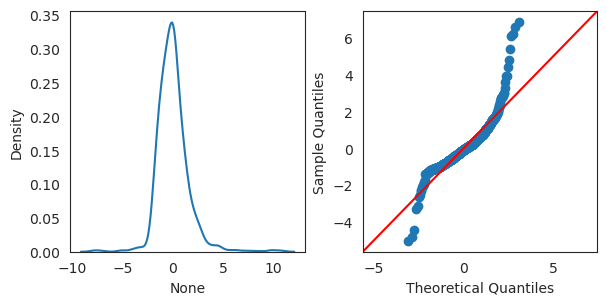

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


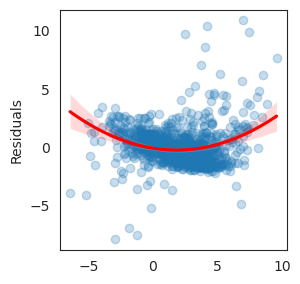

--------------------------------------------------
Numerical inputs: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']
--------------------------------------------------


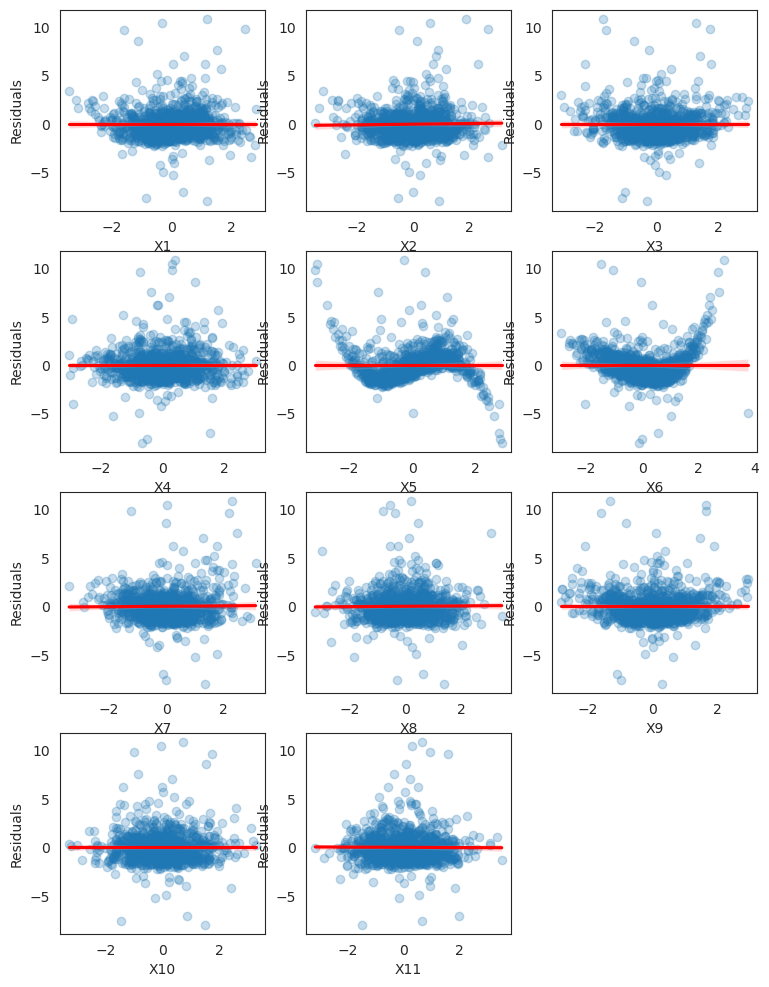

--------------------------------------------------
No categorical inputs exist.
--------------------------------------------------


In [25]:
%run -i "../3_1_LinearRegression/3_1_ResidualPlots.py"

XTR_for_res_plt = SFS_pipe.named_steps["preprocessor"].transform(XTR)
XTR_for_res_plt.columns = inputs
ResidualPlots(model= selected_model_info["model"].named_steps["sfs"].estimator,
             data=XTR_for_res_plt, num_inputs=inputs)

---

::: {.callout-note icon=false}

### Analysis of the Model Selection Process

In this particular example the selected model has significant coefficients for all the input variable it uses. Even if we expect that to be usually the case, you shoud keep in mind that that is not the way that the models are being compared and selected. We are using cross validation with measures such as $R^2$ and AIC that do not take significance into account. 

:::

The following plot shows the evolution of AIC in the loop. The horizontal dashed line indicates the value that corresponds to the selected model. 

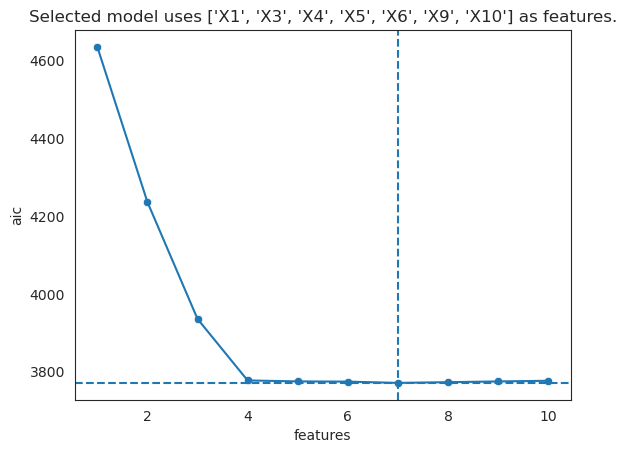

In [26]:
aic_pd = pd.DataFrame({'features':range(1,len(inputs)),
              'aic':[SFS_pipe_search[k]["aic"] for k in range(len(SFS_pipe_search))]})
sns.scatterplot(aic_pd, x="features", y="aic")
sns.lineplot(aic_pd, x="features", y="aic")
plt.axvline(x=len(selected_model_info['varSelection']), ls = '--')
plt.axhline(y=SFS_pipe_search[whichBest]["aic"], ls = '--')
plt.title(f'Selected model uses {selected_model_info["varSelection"]} as features.')
plt.show();

::: {.callout-tip  icon=false}

### Exercise 001

Change the selection direction to `backward` and examine the results. Do not let the output of the for loop confuse you! Even though each loop increases the number of inputs, the internal `SequentialFeatureSelector` process will proceed from a model with all inputs to the desired number of inputs.

:::

---

# Recursive Feature Elimination

::: {.callout-note icon=false}

### RFE and the Importance of the Predictors 

**Recursive feature selection (RFE)** is an alternative approach to the forward and backward strategies that we have just seen. Those strategies are guided by global properties of the models: either cross validation scores or metrics such as AIC. In RFE we instead focus on the **importance** of each individual feature, as indicated by the size (absolute value) of their coefficients in the case of a linear model (after scaling of the dataset). 

To perform RFE,  we begin by training a model using the complete set of inputs. The trained model is used to assign importance value to each of these features. Then the least important variable (or variables) are removed and a new model is retrained using the remaining ones. This method can be combined with some cross-validation strategy (using one of the *vertical* performance measures) to select an optimal number of features for the model. 

The RFE process should remind you of the backward strategy. But the difference between them is in the way that the *next* model is selected: in the backward strategy we use a horizontal measure to compare all models of a given size, while in RFE the feature importance is used to prune the model. 


:::

::: {.callout-note icon=false}

### RFE in scikit

RFE is implemented in Python through the [`RFE` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) and also in a particularly useful class called [`REFCV`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) which combines RFE with cross validation for the automatic selection of the optimal number of features. 

Let us see how to apply it to our previous example. Since the training and test sets and the formula for the complete model are all already available we move directly to the modeling pipeline. 

:::

Recall that our model formula has no intercept:

In [27]:
model_Formula

'num__X1 + num__X2 + num__X3 + num__X4 + num__X5 + num__X6 + num__X7 + num__X8 + num__X9 + num__X10 + num__X11 - 1'

We define and fit the RFECV pipeline. Things are simpler here as we get automatic selection of the optimal number of features (no need of a for loop):

In [28]:
num_folds = 10

RFECV_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ("formula", FormulaTransformer(model_Formula)),
            ('rfecv', RFECV(StatsModelsRegressor(OLS, fit_intercept = True, scoring='neg_mean_squared_error'), 
            step=1, 
            cv=num_folds)) 
        ])

RFECV_pipe.fit(XTR, YTR) 

,steps,"[('preprocessor', ...), ('formula', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Now we can get the selected features as before:

In [29]:
RFECV_pipe.named_steps["rfecv"].feature_names_in_ = np.array(inputs)
isVarSelected = RFECV_pipe.named_steps["rfecv"].support_
varSelection = RFECV_pipe.named_steps["rfecv"].feature_names_in_[isVarSelected]
varSelection

array(['X1', 'X3', 'X5', 'X6', 'X9', 'X10'], dtype='<U3')

As we can see, the result includes all the inputs selected by the forward and backward strategies, but there is an additional feature `X3`. Let us examine the fitted model which is again a Statsmodels object:

In [30]:
RFECV_pipe_model = RFECV_pipe.named_steps["rfecv"].estimator_
RFECV_pipe_model

,model_class,<class 'stats...ar_model.OLS'>
,fit_intercept,True


And we get the model summary as before:

In [31]:
XTR_selected_pd = pd.DataFrame(RFECV_pipe.named_steps["rfecv"].transform(XTR), columns=varSelection)
print(RFECV_pipe_model.fit(XTR_selected_pd, YTR.reset_index(drop=True)).results_.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     385.9
Date:                Wed, 18 Feb 2026   Prob (F-statistic):          1.86e-255
Time:                        10:07:40   Log-Likelihood:                -1879.6
No. Observations:                1000   AIC:                             3773.
Df Residuals:                     993   BIC:                             3808.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8681      0.050     37.110      0.0

::: {.callout-note icon=false}

### Analysis of the Selected Model

Note that the coefficient of some variables in the selected model could be non significant. Again this is a consequence of the feature selection procedure not using statistical significance (but feature importance).  The AIC value is almost identical to the one we got using forward selection. Therefore, in this example forward selection seems to be doing a better job at selecting features. The advantage of `RFECV` is in terms of ease of use, as the for loop is not needed. The following plot illustrates the cv scores that lead to the selection of the number of features (the dashed lines indicate the number of features and the corresponding score for that selection). 

:::

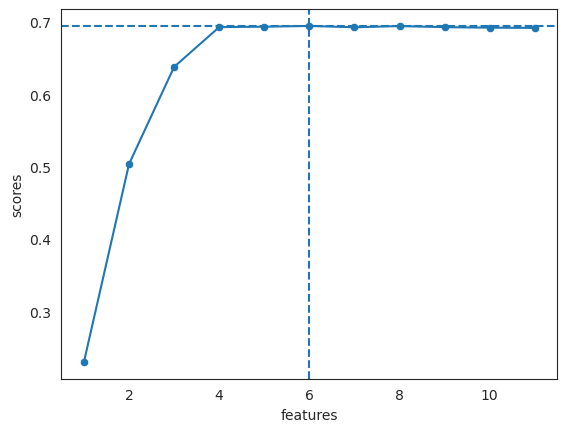

In [32]:
scores_pd = pd.DataFrame({'features':range(1,len(inputs)+1),
              'scores':RFECV_pipe.named_steps["rfecv"].cv_results_['mean_test_score']})
sns.scatterplot(scores_pd, x="features", y="scores")
sns.lineplot(scores_pd, x="features", y="scores")
plt.axhline(y=scores_pd["scores"].max(), ls = '--')
plt.axvline(x=varSelection.shape[0], ls = '--')
plt.show();

In [33]:
scores_pd["scores"]

0     0.230291
1     0.503592
2     0.637702
3     0.692652
4     0.693207
5     0.694266
6     0.692366
7     0.694090
8     0.692541
9     0.691855
10    0.691518
Name: scores, dtype: float64

---

::: {.callout-note icon=false}

### Validation and Test Scores of the Model

In this particular example the selected model has significant coefficients for all the input variable it uses. Even if we expect that to be usually the case, you shoud keep in mind that that is not the way that the models are being compared and selected. We are using cross validation with measures such as $R^2$ and AIC that do not take significance into account. 

:::

In [34]:
RFE_val_scores = cross_val_score(RFECV_pipe_model, XTR_selected_pd, YTR.reset_index(drop=True), cv=10, scoring="neg_mean_squared_error")
RFE_val_scores

array([-1.99511628, -2.33834018, -1.53777678, -1.60669992, -3.07963132,
       -1.89906504, -2.30713765, -2.45906988, -4.22282167, -4.12782631])

In [35]:
RFECV_pipe_model


,model_class,<class 'stats...ar_model.OLS'>
,fit_intercept,True


In [36]:
XTS_selected_pd = pd.DataFrame(RFECV_pipe.named_steps["rfecv"].transform(XTS), columns=varSelection)
XTS_selected_pd


,X1,X3,X5,X6,X9,X10
0,-1.623552,-5.340823,-0.670501,0.980370,-0.782473,0.540350
1,-2.023386,19.906353,1.241473,-1.080460,3.016985,1.946878
2,2.204650,5.981740,-0.711047,-0.310462,0.789065,0.631742
3,1.112091,-0.597322,-0.990069,-0.917676,-0.290526,0.976322
4,-0.927588,-2.073156,-1.777529,1.213873,-0.044390,0.265506
...,...,...,...,...,...,...
245,-0.219244,-13.247836,-0.135511,-0.256402,-2.012584,0.168967
246,2.500051,-0.446588,-0.346454,0.244533,-0.026462,0.357007
247,0.501914,1.119308,1.389443,0.496103,0.161849,2.135842
248,0.306868,-6.196531,-0.202906,-0.280527,-0.992225,0.779191


In [37]:
Y_RFE_pred = RFECV_pipe_model.predict(XTS_selected_pd[varSelection])
Y_RFE_pred


0      2.803276
1     -5.283380
2      3.110660
3      1.593541
4      5.602998
         ...   
245    1.573137
246    4.066295
247   -1.343169
248    1.217297
249   -2.223504
Length: 250, dtype: float64

In [38]:
RFE_test_score =-np.sqrt(mean_squared_error(Y_RFE_pred, YTS.reset_index(drop=True)))
RFE_test_score

np.float64(-2.279758648927032)

In [39]:
modelDict['RFE'] = {'val_scores':RFE_val_scores, 'test_score':RFE_test_score}

::: {.callout-note icon=false}

### Residual Plots

Uncomment and run the next cells to get the residual plots.

:::

--------------------------------------------------
Density Curve and QQ-plot of Residuals: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']
--------------------------------------------------
[<Axes: > <Axes: >]


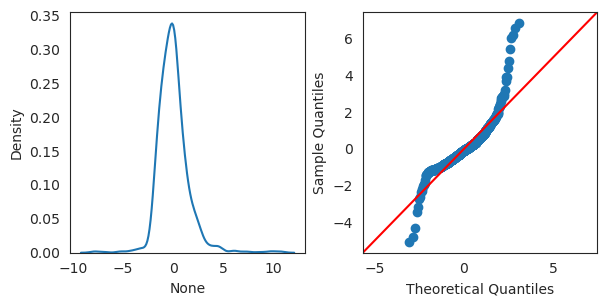

--------------------------------------------------
Fitted Values vs Residuals:
--------------------------------------------------


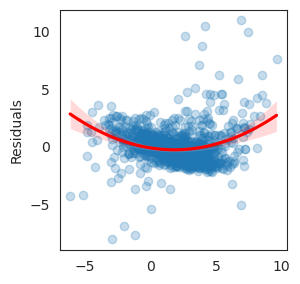

--------------------------------------------------
Numerical inputs: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']
--------------------------------------------------


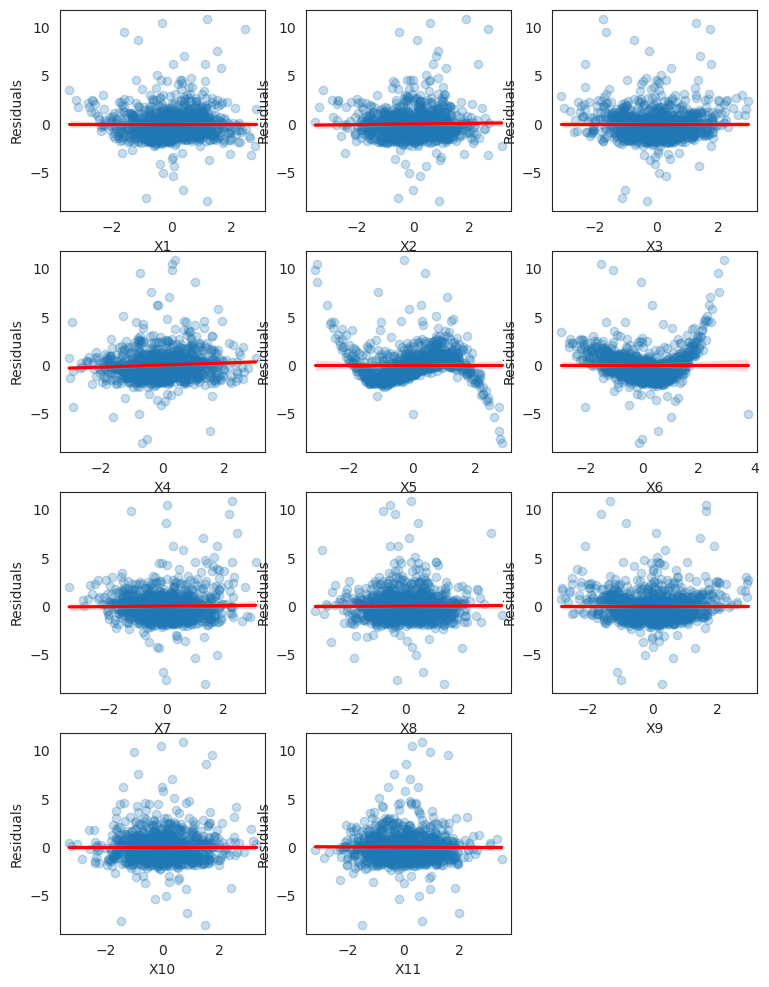

--------------------------------------------------
No categorical inputs exist.
--------------------------------------------------


In [40]:
%run -i "../3_1_LinearRegression/3_1_ResidualPlots.py"
XTR_for_res_plt = RFECV_pipe.named_steps["preprocessor"].transform(XTR)
XTR_for_res_plt.columns = inputs
ResidualPlots(model= RFECV_pipe_model,
             data=XTR_for_res_plt, num_inputs=inputs)

---

# Regularization: Lasso, Ridge and Related Shrinkage Methods.

::: {.callout-note icon=false}

### Regularization and Shrinkage Metods

We have already met a first concept of regularization when we discussed the support vector machines and introduced a penalty term for trespassing the margin. The same idea can be applied to linear models as follows. Remember that in least squares we find the estimates of the linear model coefficients by minimizing the sum of squared residuals (the usual loss function for this method). That is, we minimize:
$$
SS_{residual} = (\bar Y - {\mathbf X}\hat\beta)^T (\bar Y - {\mathbf X}\hat\beta)
$$
In a regularization  method we choose a value of a hyperparameter $\lambda$ and then add a **penalty term** to the above expression, to get
$$
(\bar Y - {\mathbf X}\hat\beta)^T (\bar Y - {\mathbf X}\hat\beta) + \lambda\cdot\text{penalty}
$$
The model coefficient estimates are found as before by miinizing this quantity for the selected value of $\lambda$.

A good choice of penalty term should be related to the **complexity of the model**. In linear models the complexity of the model is related to its coefficients, and therefore the typical penalty terms provide a measure of the number and/or size of the model's coefficients. Then, as the value of $\lambda$ increases the penalty applied forces the model to search for a model with less and/or smaller coefficients. This makes the coefficients *shrink* and that is the reason why these are called **shrinkage methods**.

Let us see two frequently used shrinkage methods, that differ on the kind of penalty term they use. 


:::

---

::: {.callout-note icon=false}

### The Lasso

Let us suppose that we are trying to fit a linear model with $p$ input variables, and so
$$
f(\bar X) = \beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p
$$
Just like we did in the session about support vector machines, assume that we take a fixed **complexity budget** $S$ that we are allowed to *spend* in the coefficients of the model. To make this precise we introduce the **Lasso penalty** as the sum of the absolute values of the model coefficients (Lasso = Least absolute shrinkage and selection operator):
$$\displaystyle\sum_{i = 1}^p|\beta_i|$$
The Lasso penalty term $\displaystyle\sum_{i = 1}^p|\beta_i|$ is also called the $L_1$ norm of the vector of input coefficients $(\beta_1,\ldots,\beta_p)$ (the intercept is excluded). Therefore in the Lasso we fit the model by trying to solve the optimization problem
$$
\operatorname{argmin}_{(\beta_1,\ldots,\beta_p)}\left(\sum_{i = 1}^n\left(y_i - \beta_0 - \beta_1 x_{i1} - \cdots - \beta_p x_{ip} \right)^2\right)\qquad 
\text{ subject to }\quad \displaystyle\sum_{i = 1}^p|\beta_i|\leq S
$$
That is, find the values of $(\beta_1,\ldots,\beta_p)$ that result in the minimum of the function inside the parenthesis, while keeping the coefficients sizes small enough to fulfill the complexity requirement. 

:::

::: {.callout-note icon=false}

### Another formulation for the Lasso.

When you learnt Calculus you may have come across the idea of *Lagrange Mulipliers* for constrained optimization problems. Applying that idea to the above expression of the Lasso as one such problem we can obtain the following equivalent dual formulation:
$$
\operatorname{argmin}_{(\beta_1,\ldots,\beta_p)}\left(\sum_{i = 1}^n\left(y_i - \beta_0 - \beta_1 x_{i1} - \cdots - \beta_p x_{ip} \right)^2 + \lambda\,\underbrace{\displaystyle\sum_{i = 1}^p|\beta_i|}_{\text{Lasso penalty}}\right)
$$
for a given *fixed* $\lambda$. This version of the Lasso shows that it is indeed a regularization method, because it that can be expressed as:
$$
(\bar Y - {\mathbf X}\hat\beta)^T (\bar Y - {\mathbf X}\hat\beta) + \lambda\,\underbrace{\displaystyle\sum_{i = 1}^p|\beta_i|}_{\text{Lasso penalty}}
$$

:::

---

::: {.callout-note icon=false}

### Geometric Interpretation of the Lasso.

Let us return to the first version of the Lasso in a problem with two inputs, so that we can visualize what is going on. Let us further suppose that the data has been centered so that $\beta_0 = 0$. Then the Lasso asks for the solution of:
$$
\operatorname{argmin}_{(\beta_1, \beta_2)}\left(\sum_{i = 1}^n\left(y_i - \beta_1 x_{i1} - \beta_2 x_{i2} \right)^2\right)\qquad 
\text{ subject to }\quad |\beta_1| + |\beta_2| \leq S
$$
If we ignore the condition $|\beta_1| + |\beta_2| \leq S$ and just try to minimize the residual sum of squares:
$$
F(\beta_1, \beta_2) = \sum_{i = 1}^n\left(y_i - \beta_1 x_{i1} - \beta_2 x_{i2} \right)^2
$$
the solution will be the coefficients $(\beta_1^{OLS}, \beta_2^{OLS})$ from ordinary least squares (OLS). The plots below will represent points like this in the $(\beta_1, \beta_2)$ plane. The level curves of $F(\beta_1, \beta_2)$ (the points where $F$ takes a given fixed value) can be shown to be ellipses in this plane. The Lasso condition on the other hand $|\beta_1| + |\beta_2| \leq S$ defines a diamond shaped region in the plane. The Lasso optimization requires us to find the point in the diamond region where the value of $F$ is mininmal. The plot below illustrates a typical solution:

![](./fig/3_2_Lasso01.png){width=50% fig-align="center" fig-alt="Geometric Interpretation of the Lasso Optimization in 2D"}

This plot is produced by a [dynamic geometric construction (made with GeoGebra)](https://www.geogebra.org/m/xa4dffju) (included here, in the cell below this one), that we will try to use in this session to illustrate how the Lasso works. In case you can not get it to work the static images below can help follow the discussion. The blue diamond is the boundary of the region of points $(\beta_1, \beta_2)$ with $|\beta_1| + |\beta_2| \leq S$ for a particular choice of $S$. The point labelled $LS_{solution}$ corresponds to the OLS fitted model without using the Lasso. For this value of $S$ the point is outside the diamond, so the model can not use it. The red ellipse represents the level curve of $F$ with the minimum value of the function that still touches the diamond region. The point $(\beta_1, \beta_2)$ where the diamond and the ellipse meet corresponds to the Lasso solution for this choice of $S$. 

Of course, with a bigger value of $S$ the diamond region becomes larger. And when it reaches the $LS_{solution}$ (which is the absolute minimum of $F$) the Lasso restriction becomes irrelevant.

:::


[Direct GeoGebra link](https://www.geogebra.org/m/xa4dffju)

<iframe scrolling="no" title="3_2_Lasso_Illustration" src="https://www.geogebra.org/material/iframe/id/kq7pzsav/width/1182/height/771/border/888888/sfsb/true/smb/false/stb/false/stbh/false/ai/false/asb/false/sri/true/rc/false/ld/false/sdz/true/ctl/false" width="800px" height="600px" style="border:0px;"> </iframe>

::: {.callout-note icon=false}

### Feature Selection with the Help of the Hyperparameter S.

On the other hand if we reduce the *complexity budget* by making S smaller something interesting happens when we reach the situation in the plot below: 

![](./fig/3_2_Lasso02.png){width=50% fig-align="center" fig-alt="Feature Selection in the Lasso"}

For this value of $S$ the point where the diamond and the ellipse meet is in the horizontal axis. That means that $\beta_2 = 0$ and so the Lasso fitted model does not use the second input. Feature selection happens automatically in the Lasso as we decrease $S$. 

Now we can reduce the budget even further. A lower value of $S$ is represented by the smaller green diamond below. The black ellipse illustrates that once the problem reaches the axis, the contact point between diamonds and ellipses will remain in the axis, keeping $\beta_2 = 0$. As $S$ decreases it is now the turn of $\beta_1$ to become smaller until it also becomes zero (in a typical implementation where $\beta_0$ has not been forced to be 0, the optimization will continue adjusting the value of the model intercept as we decrease $S$ / increase $\lambda$).

![](./fig/3_2_Lasso03.png){width=50% fig-align="center" fig-alt="Further Feature Selection in the Lasso"}

This example illustrates a general **automatic feature selection property of the Lasso** that holds in higher dimensions: **as the regularization parameter $\lambda$ increases, the coefficients of the model shrink until eventually they all become equal to zero.** If we combine this property with cross validation using hyperparameter search we can use the Lasso and find the number of variables (remaining non zero coefficients) where the model performance is best.


:::

---

::: {.callout-note icon=false}

### The Lasso in Python

The Lasso method is implemented in scikit through [the Lasso class](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html). It provides a regularization parameter called `alpha` which is the analogue of the $\lambda$ above: smaller values of `alpha` correspond to more complexity (a bigger budget for coefficients of the model). And `alpha = 0` corresponds to basic linear regression modeling  with no regularization. 

We will use the same pipeline and patsy formulas (with no intercept) framework to inspect the resulting fitted models. 

:::

In [41]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler().set_output(transform="pandas"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_inputs),
        ('cat', 'passthrough', cat_inputs)
        ])
preprocessor.set_output(transform='pandas')
preprocessor.fit_transform(XTR)

model_Formula = " + ".join(["num__"+ item for item in inputs])
model_Formula = model_Formula + " - 1"
model_Formula


'num__X1 + num__X2 + num__X3 + num__X4 + num__X5 + num__X6 + num__X7 + num__X8 + num__X9 + num__X10 + num__X11 - 1'

We use `alpha` as a hyperparameter for the Lasso pipeline. 

In [42]:
logScale = True
if logScale:
    Lasso_alphas = np.logspace(-5, 5, 51)
else:
    Lasso_alphas = np.linspace(0.001, 0.01, 21)


In [43]:
Lasso_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ("formula", FormulaTransformer(model_Formula)),
            ('Lasso', Lasso())])
Lasso_pipe.fit(XTR, YTR)

,steps,"[('preprocessor', ...), ('formula', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


We want to be able to explore the evolution of the coefficients of the model as `alpha` changes. Therefore we will use a for loop and we will keep a record of the coefficients in the list called `coeffs`.

In [44]:
num_folds = 10
coefs = []
scores = []

for alpha in Lasso_alphas:
    # param_iter = {'Ridge_model__alpha': [alpha]}
    Lasso_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('Lasso', Lasso(alpha=alpha))
        ])
    Lasso_pipe.fit(XTR, YTR)
    scores.append(cross_val_score(Lasso_pipe, XTR, YTR, scoring='neg_mean_squared_error', cv=num_folds).mean())
    Lasso_pipe.named_steps["Lasso"].feature_names_in_ = np.array(inputs)
    coefs.append(Lasso_pipe.named_steps["Lasso"].coef_)

The maximum cross validation score and the corresponding value of  `alpha` are

In [45]:
scores[np.argmax(scores)], Lasso_alphas[np.argmax(scores)]

(np.float64(-2.5759645494858865), np.float64(0.006309573444801936))

And now we can make a plot that shows how the absolute value  of the coefficients decreases as `alpha` increases until they all become eventually equal to 0.The dashed line indicates the value with the best validation score. 

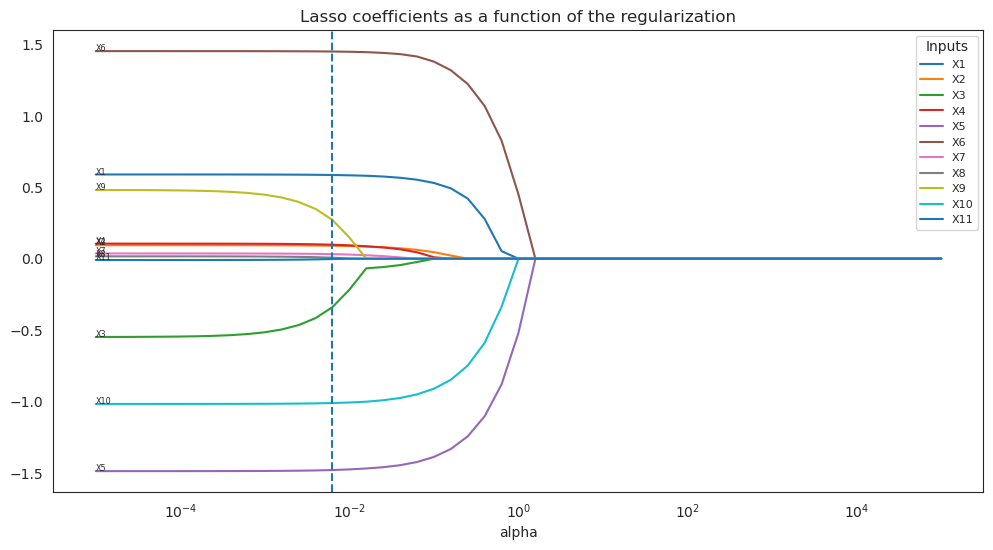

In [46]:
coefs_pd = pd.DataFrame(coefs, columns=inputs)
coefs_pd["alpha"] = Lasso_alphas

fig, ax = plt.subplots()
coefs_pd.plot(x = "alpha", y = inputs, logx=logScale, ax = ax)
fig.set_figwidth(12)
fig.set_figheight(6)
plt.legend(loc='upper right', title='Inputs', prop={'size': 8})
plt.title('Lasso coefficients as a function of the regularization')
for k in range(len(inputs)):
    plt.text(Lasso_alphas[0], coefs_pd.iloc[1, k], s = inputs[k], fontsize='xx-small')
plt.axvline(x=Lasso_alphas[np.argmax(scores)], ls = '--')
plt.show();


---

::: {.callout-note icon=false}

### A Grid for the Lasso

Usually we would directly use a grid search with cross validation for the lasso (instead of the for loop above) like this:

:::

In [47]:
Lasso_hyp_grid = {'Lasso__alpha': Lasso_alphas}

Lasso_grid = GridSearchCV(estimator=Lasso_pipe, 
                       param_grid=Lasso_hyp_grid, 
                       n_jobs=-1,  
                       scoring='neg_mean_squared_error',  
                       cv=num_folds) 

Lasso_grid.fit(XTR, YTR)

,estimator,Pipeline(step...(100000.0)))])
,param_grid,{'Lasso__alpha': array([1.0000...00000000e+05])}
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


The value of `alpha` selected by the grid is as before

In [48]:
best_alpha = Lasso_grid.best_params_['Lasso__alpha']
best_alpha

np.float64(0.006309573444801936)

and we can also plot the evolution of the cross validation error as `alpha` changes,  Remember that this is minus the error, and so in this plot *higher is better*. The dashed lines indicate the selected value of `alpha` and the corresponding error. 

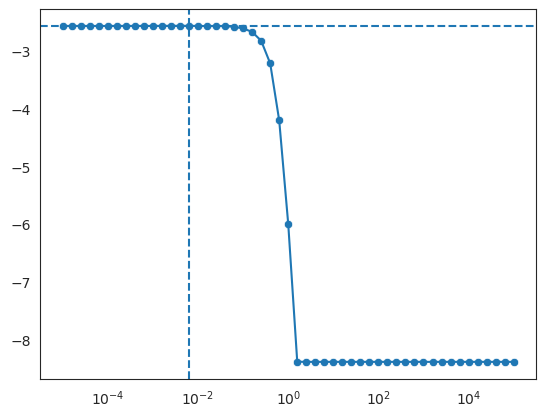

In [49]:
sns.scatterplot(x = Lasso_alphas, y = Lasso_grid.cv_results_["mean_test_score"])
sns.lineplot(x = Lasso_alphas, y = Lasso_grid.cv_results_["mean_test_score"])
plt.axhline(y=Lasso_grid.cv_results_["mean_test_score"].max(), ls = '--')
plt.axvline(x=best_alpha, ls = '--')
if logScale:
    plt.xscale('log')

::: {.callout-tip  icon=false}

### Exercise 002

Change the value of `logScale` to false to zoom in and explore closely the region of `alpha` values close to the selected one. Rerun the code up to this exercise to do that. 

:::

The coefficients of the model selected by the Lasso are all different from 0 (no feature selection for this example): 

In [50]:
position_in_grid = Lasso_alphas.tolist().index(best_alpha)
coefs_pd.iloc[position_in_grid, :-1]

X1     0.585941
X2     0.090797
X3    -0.338344
X4     0.098089
X5    -1.478577
X6     1.449819
X7     0.032112
X8     0.007230
X9     0.271059
X10   -1.009818
X11   -0.001880
Name: 14, dtype: float64

In particular all the input variables are selected as we have already seen:

In [51]:
selected_vars = [inputs[k] for k, x in enumerate((np.abs(coefs_pd.iloc[position_in_grid, :-1]) > 0).values) if x]
selected_vars

['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']

---

::: {.callout-note icon=false}

### Information for Model Comparison

Let us add the Lasso scores in validation and test to our dictionary for a later model comparison. 

:::

In [52]:
Lasso_val_scores = cross_val_score(Lasso_grid, XTR, YTR, cv=10, scoring="neg_mean_squared_error").tolist()

In [53]:
Lasso_test_score = Lasso_grid.score(XTS, YTS)

In [54]:
modelDict['Lasso'] = {'val_scores':Lasso_val_scores, 'test_score':Lasso_test_score}

---

::: {.callout-note icon=false}

### Ridge Regression

Ridge regression is another shrinkage method that differs from the Lasso in the use of the $L_2$ norm instead of the $L_1$. That means that in Ridge regression we ask for the solution of:
$$
\operatorname{argmin}_{(\beta_1,\ldots,\beta_p)}\left(\sum_{i = 1}^n\left(y_i - \beta_0 - \beta_1 x_{i1} - \cdots - \beta_p x_{ip} \right)^2\right)\qquad 
\text{ subject to }\quad \underbrace{\displaystyle\sum_{i = 1}^p|\beta_i^2\leq S}_{\textbf{ Note the squares here!}}
$$
This in turn implies that the geometry of the Ridge regression is defined by a ball in the coefficient space, like the blue ball in the 2d picture below. And therefore as $S$ decreases (the complexity decreases and) we do not expect any individual coefficient to become actually zero. But all of them as a group become smaller and smaller with $S$.

![](./fig/3_2_Ridge01.png){width=35% fig-align="center" fig-alt="The Geometry of Ridge Regression"}

:::

<!-- <iframe scrolling="no" title="3_2_RidgeRegression" src="https://www.geogebra.org/material/iframe/id/fbcufdew/width/1440/height/847/border/888888/sfsb/true/smb/false/stb/false/stbh/false/ai/false/asb/false/sri/false/rc/false/ld/false/sdz/false/ctl/false" width="800px" height="600px" style="border:0px;"> </iframe> -->

::: {.callout-note icon=false}

### Ridge Regression in Python

This method is implemented in the [Ridge and RidgeCV classes](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html). Make sure to read their documentation

:::

::: {.callout-tip  icon=false}

### Exercise 003

In new code cells below this one take the code cells for the Lasso and modify them it to run the Ridge method, to get a plot of the *Ridge coefficients as a function of the regularization*. Do you see the difference?

:::

In [61]:
# %run -i "../exclude/MLMIINprv/exercises/3_2_Exercise_003.py"

---

# Model Comparison

The follwoing code is similar to other previous model comparisons. We compute the scores and use boxplots to illustrate cross validation results for the models to be compared.

In [56]:
val_scores = {ml:(modelDict[ml])['val_scores'] for ml in modelDict.keys()}

In [57]:
model_val_scores = pd.DataFrame(val_scores)
model_val_scores


,SFS,RFE,Lasso
0,-1.985385,-1.995116,-1.964394
1,-2.301281,-2.338340,-2.332525
2,-1.518908,-1.537777,-1.544335
3,-1.571972,-1.606700,-1.634485
4,-3.106086,-3.079631,-3.105553
5,-1.881501,-1.899065,-1.985617
6,-2.320837,-2.307138,-2.306664
7,-2.467682,-2.459070,-2.555914
8,-4.181921,-4.222822,-4.250270
9,-4.144669,-4.127826,-4.179896


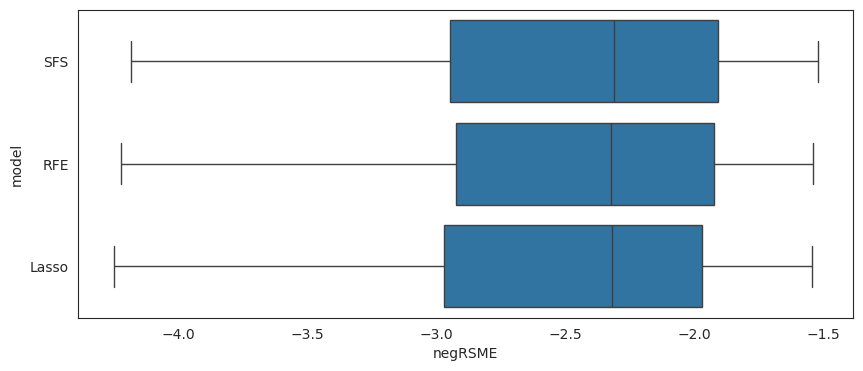

In [58]:
metric = "negRSME"
fig = plt.figure(figsize=(10, 4))
sns.boxplot(model_val_scores.melt(var_name="model", value_name=metric), x=metric, y ="model");


In [59]:
test_scores = {ml:(modelDict[ml])['test_score'] for ml in modelDict.keys()}
test_scores


{'SFS': np.float64(-2.2762748400986776),
 'RFE': np.float64(-2.279758648927032),
 'Lasso': -5.167256008319807}

::: {.callout-tip  icon=false}

### Exercise 004

What is your interpretation of these plots?

:::

<!-- Certainly! Let's e{\beta}plore the equivalence between the two formulations of the Lasso (Least Absolute Shrinkage and Selection Operator) as optimization problems.

1. **Formulation 1**:
   - **Problem**: Minimize the L1-norm of the coefficient vector `{\beta}` subject to the constraint that the L2-norm of the residual vector `A{\beta} - y` is less than or equal to a given threshold `ε`:
     $$ \min_{\beta} \|{\beta}\|_1 \quad \text{s.t.} \quad \|A{\beta} - y\|_2^2 \leq \epsilon $$

2. **Formulation 2**:
   - **Problem**: Minimize the L2-norm of the residual vector `A{\beta} - y` subject to the constraint that the L1-norm of the coefficient vector `{\beta}` is less than or equal to a given threshold `t`:
     $$ \min_{\beta} \|A{\beta} - y\|_2^2 \quad \text{s.t.} \quad \|{\beta}\|_1 \leq t $$

To see their equivalence, we can follow these steps:

- **Step 1**: Convert Formulation 1 into a saddle point problem using Lagrange multipliers:
  - Define the Lagrangian:
    $$ L({\beta}, \lambda) = \|{\beta}\|_1 + \lambda (\|A{\beta} - y\|_2^2 - \epsilon) $$
  - The saddle point problem is:
    $$ \min_{\beta} \max_{\lambda \geq 0} L({\beta}, \lambda) = \max_{\lambda \geq 0} \min_{\beta} L({\beta}, \lambda) $$

- **Step 2**: Solve for the optimal value of $\lambda$ (denoted as `$\lambda0$):
  - If $\lambda0 = 0$, the minimizer is ${\beta} = 0$ (trivial case).
  - Otherwise, we have $∥A{\beta}0 - y∥_2^2 = \epsilon$, where `{\beta}0` is the solution of Formulation 1.

- **Step 3**: Formulation 2 can be equivalently described as:
  $$ \min_{\beta} \max_{\mu \geq 0} \left( \|A{\beta} - y\|_2^2 + \mu (\|{\beta}\|_1 - t) \right) $$

- **Step 4**: Observe that the solution `(μ0, {\beta}'0)` in Formulation 2 corresponds to `(1/λ0, {\beta}0)` in Formulation 1.
  - This equivalence holds because of complementary slackness.

Therefore, the Lagrangian dual problems in both formulations are equivalent, establishing the equivalence between the two Lasso formulations. ¹²

In summary, both formulations lead to the same solution for the Lasso problem, albeit e{\beta}pressed differently. The choice between them often depends on the specific context and computational considerations.

Origen: Conversación con Bing, 23/2/2024
(1) optimization - Equivalent formulation of LASSO? - Mathematics Stack .... https://math.stacke{\beta}change.com/questions/3047347/equivalent-formulation-of-lasso.
(2) optimization - Transformation of Lasso to quadratic linear constrained .... https://bing.com/search?q=equivalent+formulations+of+the+lasso+as+an+optimization+problem.
(3) optimization - Transformation of Lasso to quadratic linear constrained .... https://math.stacke{\beta}change.com/questions/4308651/transformation-of-lasso-to-quadratic-linear-constrained-form.
(4) Robust Regression and Lasso - University of Te{\beta}as at Austin. https://users.ece.ute{\beta}as.edu/~cmcaram/pubs/{\beta}uCaramanisMannor.LassoNIPSfinal.pdf.
(5) . https://www.chegg.com/homework-help/questions-and-answers/consider-lasso-regression-problem-given-min-ly-lasso-promote-sparsity-solution-b-suppose-w-q29205669.
(6) . https://www.slideserve.com/yelena/model-selection-in-r-featuring-the-lasso.
(7) . https://www.slideshare.net/SatoshiHara3/conve{\beta}-hull-appro{\beta}imation-of-nearly-optimal-lasso-solutions.
(8) . https://jdstorey.org/fas/lasso-regression.html.
(9) . http://bigcomple{\beta}data.com/slides/PathwayLasso_CMStatistics_2016.html.
(10) . https://dataanalyticsbook.info/chapter-8-scalability-lasso-pca.html. -->

---

::: {.callout-note  icon=false}

### Recommended reading:

See [References](#References) section at the end for details.

+ Chapter 3 of [@ISLP2023]
+ Chapter 2 (pp. 47 and following) of [@IMLPY]
+ [Chapter 5 of [@PDSH]](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html)
+ Chapters 2 and 3 of [@ESLI2009] 
+ Chapter 11 of [@pml1].

:::

# References